In [33]:
import numpy as np
import matplotlib.pyplot as plt
from NumOpt.OptimizationProblem import OptimizationProblem
from NumOpt.post_processing import plot_histories

PROBLEM PARAMETERS

In [34]:
x0 = 0
x1 = 1
y0 = 1
y1 = 0
h = y0-y1
nPoints = 25

OBJECTIVE FUNCTION CALCULATION

Brachistochron travel time, parameterized by xcoordinates of the chosen points, and friction coefficient

In [35]:
def travel_time(x, *args):
    yinternals = x # design variables are the y-coordinates of the points
    ypoints = np.concatenate(([y0], yinternals, [y1]))
    
    # order of arguments
    nPoints = args[0]
    mu = args[1]
    
    xpoints = np.linspace(x0, x1, nPoints)
    res = 0
    for i in range(nPoints-1):
        num = np.sqrt((xpoints[i+1] - xpoints[i])**2 + (ypoints[i+1] - ypoints[i])**2)
        den1 = np.sqrt(h-ypoints[i+1]-mu*xpoints[i+1])
        den2 = np.sqrt(h-ypoints[i]-mu*xpoints[i]) 
        tot = num / (den1 + den2)
        res += tot
    return res

### Part 1

Solve the problem at various friction coefficient levels

In [36]:
mu1 = 1e-4
mu2 = 0.01
tol = 1e-4
maxiter = 1000
frictions = [0.0, 0.1, 0.2, 0.3]

histories = []
for friction in frictions:
    xpoints = np.linspace(x0, x1, nPoints)
    initialGuess = h + (y1-y0)*(xpoints-xpoints[0])
    prob = OptimizationProblem(nDim=nPoints-2, bounds=[(0.0, 1.0) for i in range(nPoints)])
    prob.setObjectiveFunction(travel_time, *(nPoints, friction))
    history = prob.solve(x0=initialGuess[1:-1], directionMethod='quasi_newton', 
                            stepMethod='strong_wolfe', options={'maxiter':maxiter, 'tol':tol, 'mu1':mu1, 'mu2':mu2})
    histories.append(history)
    
    print("")
    print("The case with friction", friction, "takes", len(history['x']), "iterations")
    print("and the travel time is ", history['fval'][-1], "seconds")


The case with friction 0.0 takes 38 iterations
and the travel time is  1.294180704371756 seconds

The case with friction 0.1 takes 40 iterations
and the travel time is  1.3247660305204916 seconds

The case with friction 0.2 takes 42 iterations
and the travel time is  1.3555140414583842 seconds

The case with friction 0.3 takes 43 iterations
and the travel time is  1.3868999401288622 seconds


Text(0, 0.5, '$y$')

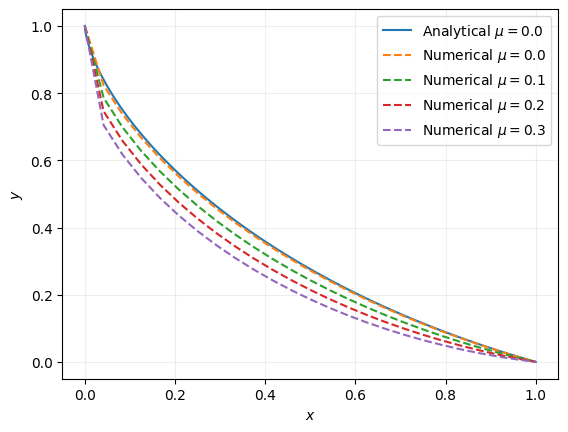

In [37]:
def analytical_solution_zerofriction(theta):
    a = 0.572917
    x = a*(theta-np.sin(theta))
    y = -a*(1-np.cos(theta))+1
    return x,y

theta = np.linspace(0, 2.412, 100)
xsol, ysol = analytical_solution_zerofriction(theta)
plt.plot(xsol, ysol, '-', label=r'Analytical $\mu=0.0$')

# compare solution with analytical function
for ih,history in enumerate(histories):
    yinternals = history['x'][-1]
    ypoints = np.concatenate(([y0], yinternals, [y1]))

    plt.plot(xpoints, ypoints, '--', ms=3, label=r'Numerical $\mu=%.1f$' % frictions[ih])

plt.legend()
plt.grid(alpha=0.2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

### Part 2

Solve the problem at various resolutions, using the warm start from previous result

In [38]:
mu1 = 1e-4
mu2 = 0.1
tol = 1e-4
maxiter = 1000
friction = 0.0
resolutions = [12, 24, 48, 96]

histories = []
for kk,nPoints in enumerate(resolutions):
    # uniform grid
    xpoints = np.linspace(x0, x1, nPoints)
    initialGuess = h + (y1-y0)*(xpoints-xpoints[0])
    
    # warm restart for larger resolutions
    # if kk==0:
    #     initialGuess = h + (y1-y0)*(xpoints-xpoints[0])
    # else:
    #     initialGuess = np.interp(xpoints, xpointsOld, ypointsOld)
        
    prob = OptimizationProblem(nDim=nPoints-2, bounds=[(0.0, 1.0) for i in range(nPoints)])
    prob.setObjectiveFunction(travel_time, *(nPoints, friction))
    history = prob.solve(x0=initialGuess[1:-1], directionMethod='quasi_newton', 
                            stepMethod='strong_wolfe', options={'maxiter':maxiter, 'tol':tol, 'mu1':mu1, 'mu2':mu2})
    histories.append(history)
    
    xpointsOld = xpoints.copy()
    yinternalsOld = history['x'][-1].copy()
    ypointsOld = np.concatenate(([y0], yinternalsOld, [y1]))
    
    print("")
    print("The case with ", nPoints, " points takes", len(history['x']), "iterations")
    print("and the travel time is ", history['fval'][-1], "seconds")


The case with  12  points takes 19 iterations
and the travel time is  1.2982171858325227 seconds

The case with  24  points takes 37 iterations
and the travel time is  1.294325428901232 seconds

The case with  48  points takes 67 iterations
and the travel time is  1.2925743793008515 seconds

The case with  96  points takes 125 iterations
and the travel time is  1.2917462482045574 seconds


Text(0.5, 1.0, 'Error in $y$')

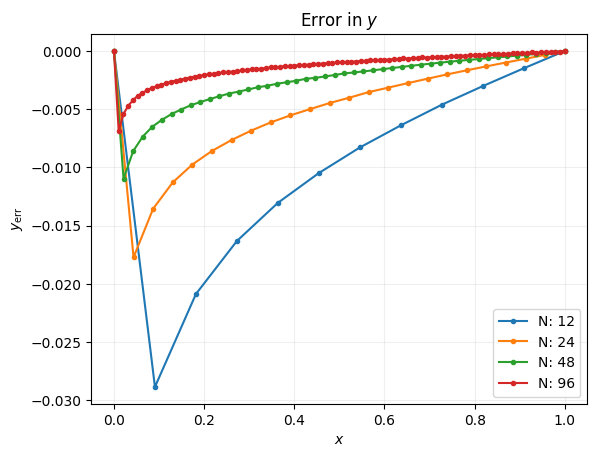

In [39]:
# plot errors with analytical solution
for ih,history in enumerate(histories):
    yinternals = history['x'][-1]
    ypoints = np.concatenate(([y0], yinternals, [y1]))
    xpoints = np.linspace(x0, x1, len(ypoints))
    truth = np.interp(xpoints, xsol, ysol)
    plt.plot(xpoints, (ypoints-truth), '-o', ms=3, label=r'N: %i' % len(xpoints))

plt.legend()
plt.grid(alpha=0.2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y_{\rm err}$')
plt.title(r'Error in $y$')